In [0]:
# Fazer uma visualização em mapa com latitude e longitude de pickups e dropoffs noano de 2010.
# QUESITOS MÍNIMOS:
# Qual a distância média percorrida por viagens com no máximo 2 passageiros?
# Quais os 3 maiores Vendors em quantidade total de dinheiro arrecadado?
# Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro.
# Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia,nos últimos 3 meses de 2012.

# QUESITOS BÔNUS:
# Qual o tempo médio das corridas nos dias de sábado e domingo?
# Fazer uma visualização em mapa com latitude e longitude de pickups e dropoffs noano de 2010.
# Conseguir simular um streaming dos dados dos JSONs e fazer uma visualizaçãoacompanhando uma métrica “em tempo-real”.
# Conseguir provisionar todo seu ambiente em uma cloud pública, de preferência AWS.

In [0]:
# disclaimer: Decidi fazer todas as queries no pandas por facilidade, caso queira usar o bigquery no notebook aqui está um exemplo:
# from google.colab import auth
# auth.authenticate_user()

%%bigquery --project  datasprintsteste  dataframename
SELECT *
FROM `datasprintsteste.datasets.NYCTaxiTrips2009`
LIMIT 1

-- (os datasets do bigquery não estão corrigidos, possuem apenas o mês de janeiro)

,total_amount,surcharge,fare_amount,dropoff_latitude,pickup_datetime,rate_code,passenger_count,tolls_amount,trip_distance,pickup_longitude,tip_amount,vendor_id,pickup_latitude,store_and_fwd_flag,payment_type,dropoff_datetime,dropoff_longitude
0,9.9,0.0,8.9,40.751203,2009-01-06 07:00:00+00:00,,1,0.0,2.79,-73.991155,1.0,VTS,40.71747,,Credit,2009-01-06 07:05:00+00:00,-73.975962


# QUESITOS MÍNIMOS:


##Preparando os Dados:

In [0]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
trips_2009 = pd.read_json('https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2009-json_corrigido.json',lines=True)
trips_2010 = pd.read_json('https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2010-json_corrigido.json',lines=True)
trips_2011 = pd.read_json('https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2011-json_corrigido.json',lines=True)
trips_2012 = pd.read_json('https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2012-json_corrigido.json',lines=True)

payment = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Teste Técnico Data Sprints/Datasets/data-payment_lookup-csv.csv')
vendors = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Teste Técnico Data Sprints/Datasets/data-vendor_lookup-csv.csv')

frames = [trips_2009,trips_2010,trips_2011,trips_2012]
trips = pd.concat(frames,ignore_index=True,sort=True)

In [0]:
trips.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2009-04-21T18:57:09.433767+00:00,40.747950,-73.994712,5.4,2,Cash,2009-04-21T18:51:11.767205+00:00,40.742950,-74.004114,NaN,NaN,0.0,0.0,0.0,5.4,0.80,CMT
1,2009-01-13T07:50:36.386011+00:00,40.792385,-73.940449,15.4,1,Cash,2009-01-13T07:40:07.639754+00:00,40.747784,-73.996506,NaN,NaN,0.0,0.0,0.0,15.4,5.40,CMT
2,2009-01-06T19:43:09.908429+00:00,40.768108,-73.944535,6.1,5,CASH,2009-01-06T19:30:44.142187+00:00,40.752070,-73.951340,NaN,NaN,1.0,0.0,0.0,7.1,1.67,VTS
3,2009-09-24T08:41:56.739991+00:00,40.721812,-73.958122,12.9,1,CASH,2009-09-24T08:28:09.004451+00:00,40.729128,-74.001117,NaN,NaN,0.5,0.0,0.0,13.4,4.13,VTS
4,2009-10-29T05:57:22.880174+00:00,40.776075,-73.979757,7.7,1,CASH,2009-10-29T05:50:39.214629+00:00,40.756873,-73.976600,NaN,NaN,0.5,0.0,0.0,8.2,2.03,VTS


In [0]:
# dropando algumas colunas para nos salvar um pouco de RAM
trips = trips.drop(['fare_amount','rate_code','store_and_fwd_flag','surcharge','tolls_amount'],axis=1)
# trips.head()

In [0]:
# Convertendo as colunas para datetime
def conv_datetime(date_time):
  date_time = date_time.split('-')
  year = int(date_time[0])
  month = int(date_time[1])
  day = int(date_time[2][0:2])
  
  time = date_time[2][4:].split(':')
  hour = int(time[0])
  minu = int(time[1])
  sec = int(time[2][:2])
  return datetime.datetime(year,month,day,hour,minu,sec)

conv_datetime(trips.pickup_datetime[0])

trips.pickup_datetime = trips.pickup_datetime.apply(conv_datetime)
trips.dropoff_datetime = trips.dropoff_datetime.apply(conv_datetime)
# exemplo:
# trips.iloc[1].pickup_datetime.month

In [0]:
# criando colunas de data para facilitar os groupby
trips['day'] = pd.Series(np.array([i.day for i in trips.pickup_datetime]))
trips['month'] = pd.Series(np.array([i.month for i in trips.pickup_datetime]))
trips['year'] = pd.Series(np.array([i.year for i in trips.pickup_datetime]))

In [0]:
payment.head()

,A,B
0,payment_type,payment_lookup
1,Cas,Cash
2,CAS,Cash
3,Cre,Credit
4,CRE,Credit


In [0]:
# merge de payment com trips
payment = payment.rename(columns={'A': 'payment_type', 'B': 'payment_lookup'})
trips = pd.merge(trips,payment, on='payment_type')
# trips.payment_lookup.head()

## Qual a distância média percorrida por viagens com no máximo 2 passageiros?


In [0]:
td_mean = np.mean(trips.loc[trips.passenger_count <= 2,'trip_distance'])
td_mean

2.662526996203199

In [0]:
td_median = np.median(trips.loc[trips.passenger_count <= 2,'trip_distance'])
td_median 

1.6800000000000002

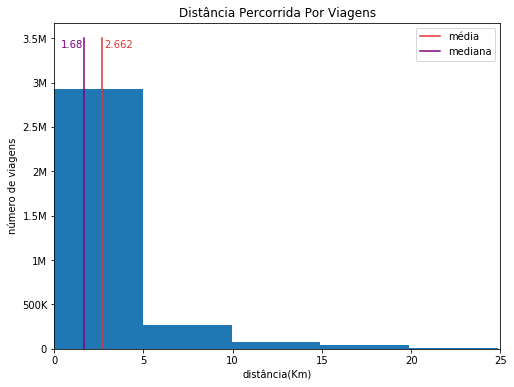

In [0]:
plt.subplots(figsize = (8,6))
plt.hist(trips.loc[trips.passenger_count <= 2,'trip_distance'])
plt.xlim((0,25))
plt.yticks(list(range(0,3500001,500000)),['0','500K','1M','1.5M','2M','2.5M','3M','3.5M'])
plt.xlabel('distância(Km)')
plt.ylabel('número de viagens')

plt.text(2.8, 3400000, '2.662',color=(0.9,0.2,0.2))
plt.text(0.4, 3400000, '1.68',color=(0.5,0.0,0.5))


plt.plot([td_mean,td_mean],[0,3500000],c=(0.9,0.2,0.2),label='média')
plt.plot([td_median,td_median],[0,3500000],c=(0.5,0.0,0.5),label='mediana')
plt.title('Distância Percorrida Por Viagens')
plt.legend()
plt.show()

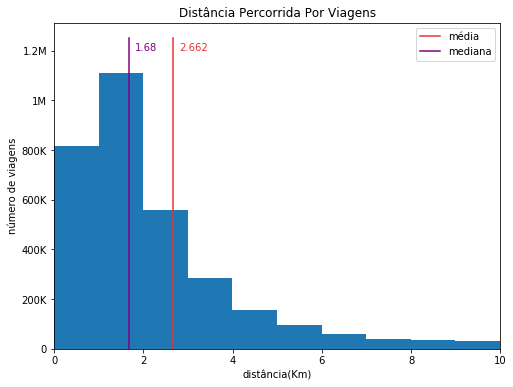

In [0]:
trips_passenger = trips.loc[trips.passenger_count <= 2]

plt.subplots(figsize = (8,6))
plt.hist(trips_passenger.loc[trips_passenger.trip_distance < 10, 'trip_distance'])
plt.xlim((0,10))
plt.yticks(list(range(0,1200001,200000)),['0','200K','400K','600K','800K','1M','1.2M'])
plt.xlabel('distância(Km)')
plt.ylabel('número de viagens')

plt.text(2.8, 1200000, '2.662',color=(0.9,0.2,0.2))
plt.text(1.8, 1200000, '1.68',color=(0.5,0.0,0.5))


plt.plot([td_mean,td_mean],[0,1250000],c=(0.9,0.2,0.2),label='média')
plt.plot([td_median,td_median],[0,1250000],c=(0.5,0.0,0.5),label='mediana')

plt.title('Distância Percorrida Por Viagens')
plt.legend()
plt.show()

## Quais os 3 maiores Vendors em quantidade total de dinheiro arrecadado?


In [0]:
trips.groupby(trips.vendor_id).total_amount.sum().sort_values(ascending=False)

vendor_id
CMT    1.954908e+07
VTS    1.904343e+07
DDS    2.714902e+06
TS     4.560000e+01
Name: total_amount, dtype: float64

In [0]:
trips.groupby(trips.vendor_id).total_amount.count().sort_values(ascending=False)

vendor_id
CMT    1916128
VTS    1833052
DDS     250816
TS           4
Name: total_amount, dtype: int64

## Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro.

In [0]:
#fazendo a tabela por ano
#tabela com todos os anos: frequency = trips[trips.payment_lookup=='Cash'].groupby(['year','month']).size()

frequency_2009 = trips[trips.payment_lookup=='Cash'][trips.year==2009].groupby(['month']).size()
frequency_2010 = trips[trips.payment_lookup=='Cash'][trips.year==2010].groupby(['month']).size()
frequency_2011 = trips[trips.payment_lookup=='Cash'][trips.year==2011].groupby(['month']).size()
frequency_2012 = trips[trips.payment_lookup=='Cash'][trips.year==2012].groupby(['month']).size()

frequency_2009

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


month
1     66824
2     66680
3     73948
4     71142
5     74151
6     71342
7     74076
8     74021
9     71511
10    74011
11    71424
12    21583
dtype: int64

In [0]:
# verificando a disponibilidade de meses de cada ano
print('2009:',list(frequency_2009.index.get_level_values(0)))
print('2010:',list(frequency_2010.index.get_level_values(0)))
print('2011:',list(frequency_2011.index.get_level_values(0)))
print('2012:',list(frequency_2012.index.get_level_values(0)))

2009: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2010: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [0]:
# alguns datasets não possuem certos meses. Para nossos plots não ficarem desbalanceados, vamos colocá-los manualmente
missing_month_2011 = pd.Series(np.array([0]),index= pd.Int64Index([12], dtype='int64', name='month'))
frequency_2011 = frequency_2011.append(missing_month_2011)

missing_month_2012 = pd.Series(np.array([0,0]),index= pd.Int64Index([11,12], dtype='int64', name='month'))
frequency_2012 = frequency_2012.append(missing_month_2012)

# print('2009:',list(frequency_2009.index.get_level_values(0)))
# print('2010:',list(frequency_2010.index.get_level_values(0)))
# print('2011:',list(frequency_2011.index.get_level_values(0)))
# print('2012:',list(frequency_2012.index.get_level_values(0)))

In [0]:
[0,1,7,3].index(7)

2

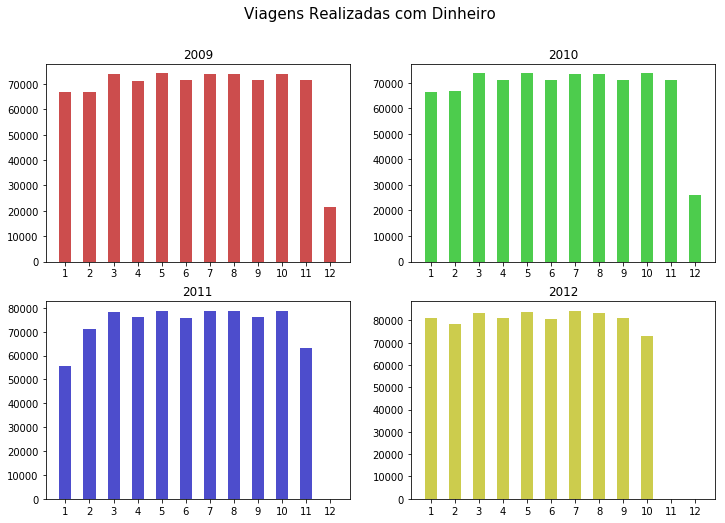

In [0]:
# fazendo os subplots:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (12,8))

ax = ax.reshape(1,-1)[0] #transformando a matriz de linhas/colunas em uma lista 1-D

x_list = [frequency_2009,frequency_2010,frequency_2011,frequency_2012]
color_list = [(0.8,0.3,0.3),(0.3,0.8,0.3),(0.3,0.3,0.8),(0.8,0.8,0.3)]
label_list = ['2009','2010','2011','2012']

for plot in ax:
  i = ax.tolist().index(plot)
  plot.bar(list(range(1,13)),x_list[i],align='center',width=0.5,color=color_list[i],label= label_list[i])
  plot.set_xticks(list(range(1,13)))
  plot.set_title(label_list[i])

fig.suptitle('Viagens Realizadas com Dinheiro',size = 15)  
plt.show()

##Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia,nos últimos 3 meses de 2012.


In [0]:
tips = trips[trips.year == 2009][trips.month >= 10].groupby(['month','day']).tip_amount.count()
tips.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


month  day
10     1      2882
       2      2981
       3      2915
       4      2864
       5      2870
Name: tip_amount, dtype: int64

No handles with labels found to put in legend.


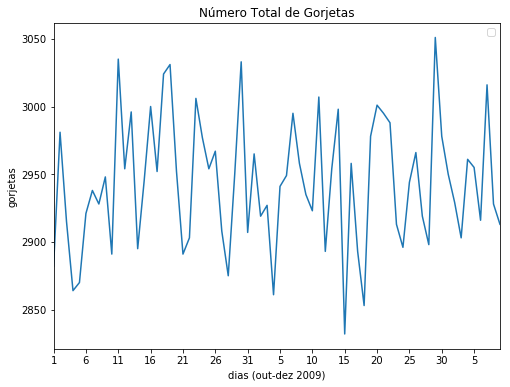

In [0]:
# podemos ver que nossos dados não tem o mês de dezembro completo
plt.subplots(figsize = (8,6))
plt.plot(list(tips))
plt.xlim(0,len(list(tips))-1)
plt.xticks(range(0,len(list(tips)),5),tips.index.get_level_values(1)[::5])
plt.xlabel('dias (out-dez 2009)')
plt.ylabel('gorjetas')
plt.title('Número Total de Gorjetas')
plt.legend()
plt.show()

#QUESITOS BÔNUS:

## Qual o tempo médio das corridas nos dias de sábado e domingo?

In [0]:
#como convertemos os valores pra datetime, eles agora podem ser subtraídos um do outro e gerar um datetime delta
trips.pickup_datetime[0].weekday()

1

In [0]:
# vamos fazer uma lista com cada uma das informações para facilitar nosso trabalho

#usamos uma list comprehension junto com o nosso delta (dividido por 60 para o resultado em minutos)
#(aviso: é bem pesado de rodar)
trips['travel_time'] = pd.Series(np.array(
                       [
                       (trips.dropoff_datetime[i] - trips.pickup_datetime[i]).seconds/60
                       for i in trips.index
                       ]))
trips['day_of_the_week'] = pd.Series(np.array([i.weekday() for i in trips.pickup_datetime]))

trips.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,...,tolls_amount,total_amount,trip_distance,vendor_id,day,month,year,payment_lookup,travel_time,day_of_the_week
0,2009-04-21 08:57:09,40.747950,-73.994712,5.4,2,Cash,2009-04-21 08:51:11,40.742950,-74.004114,NaN,...,0.0,5.4,0.8,CMT,21,4,2009,Cash,5.966667,1
1,2009-01-13 07:50:36,40.792385,-73.940449,15.4,1,Cash,2009-01-13 07:40:07,40.747784,-73.996506,NaN,...,0.0,15.4,5.4,CMT,13,1,2009,Cash,10.483333,1
2,2009-04-22 04:55:09,40.718039,-73.997466,18.7,1,Cash,2009-04-22 04:47:09,40.774511,-73.948288,NaN,...,0.0,18.7,6.0,CMT,22,4,2009,Cash,8.000000,2
3,2009-09-22 07:55:12,40.747020,-74.002378,4.9,2,Cash,2009-09-22 07:43:48,40.743155,-73.992710,NaN,...,0.0,4.9,0.5,CMT,22,9,2009,Cash,11.400000,1
4,2009-12-03 09:26:59,40.738818,-73.992199,5.3,1,Cash,2009-12-03 09:17:56,40.751590,-73.990926,NaN,...,0.0,5.3,1.1,CMT,3,12,2009,Cash,9.050000,3


In [0]:
#0 = segunda, 6 = domingo
weekends = trips[trips.day_of_the_week >= 5].travel_time
print('mean:',np.mean(weekends))
print('median:',np.median(weekends))

mean: 26.25524643454365
median: 8.783333333333333


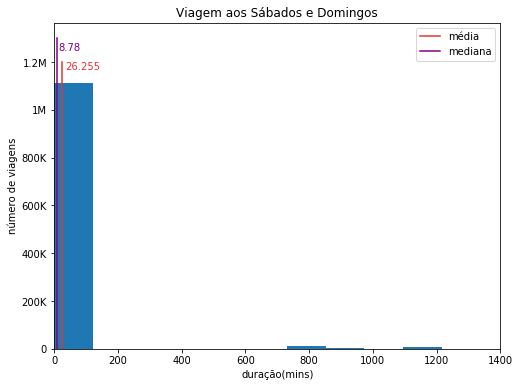

In [0]:
plt.subplots(figsize = (8,6))
plt.hist(weekends)
plt.xlim(0,1400)

plt.yticks(list(range(0,1200001,200000)),['0', '200K', '400K', '600K', '800K', '1M', '1.2M'])

plt.plot([np.mean(weekends),np.mean(weekends)],[0,1200000],c=(0.9,0.2,0.2),label='média')
plt.plot([np.median(weekends),np.median(weekends)],[0,1300000],c=(0.5,0.0,0.5),label='mediana')

plt.text(35.4, 1170000, '26.255',color=(0.9,0.2,0.2))
plt.text(15, 1250000, '8.78',color=(0.5,0.0,0.5))

plt.xlabel('duração(mins)')
plt.ylabel('número de viagens')

plt.title('Viagem aos Sábados e Domingos')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



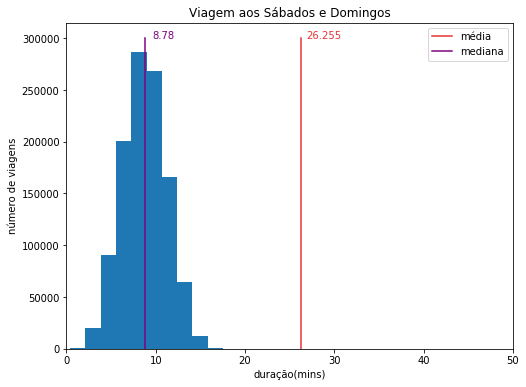

In [0]:
weekends_50 = trips[trips.day_of_the_week >= 5][trips.travel_time <= 50].travel_time

plt.subplots(figsize = (8,6))
plt.hist(weekends_50)
plt.xlim(0,50)

plt.plot([np.mean(weekends),np.mean(weekends)],[0,300000],c=(0.9,0.2,0.2),label='média')
plt.plot([np.median(weekends),np.median(weekends)],[0,300000],c=(0.5,0.0,0.5),label='mediana')

plt.text(26.9, 300000, '26.255',color=(0.9,0.2,0.2))
plt.text(9.6, 300000, '8.78',color=(0.5,0.0,0.5))

plt.xlabel('duração(mins)')
plt.ylabel('número de viagens')

plt.title('Viagem aos Sábados e Domingos')
plt.legend()
plt.show()

## Fazer uma visualização em mapa com latitude e longitude de pickups e dropoffs no ano de 2010.


In [0]:

import plotly

plotly.tools.set_credentials_file(username='mrmtonio', api_key='---')

import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = '---'

scatterpickup = go.Scattermapbox(
        lat=trips_2010.iloc[0:101].pickup_latitude,
        lon=trips_2010.iloc[0:101].pickup_longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            opacity=0.3,
            color='blue'
        ),
        text=list(range(1,101)),
    name = 'pickups')
scatterdropoff = go.Scattermapbox(
        lat=trips_2010.iloc[0:101].dropoff_latitude,
        lon=trips_2010.iloc[0:101].dropoff_longitude,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            opacity=0.3,
            color='red'
        ),
        text=list(range(1,101)),
    name = 'dropoffs')
data = [scatterpickup,scatterdropoff]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40.75,
            lon=-74
        ),
        pitch=0,
        zoom=11
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Datasprints Mapbox')